# Bayesian Change Point Analysis of COVID-19 Data

Apply the Bayesian changepoint analysis in Bayesian Methods for Hackers to COVID data

https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb

Blog posts and papers:
- http://gregorygundersen.com/blog/2019/08/13/bocd/
- https://arxiv.org/abs/0710.3742

Would be nice if this could be done in Pyro.

## Model

I want to see if I can back out the date virus growth changed, and test its accuracy against the social distancing measures. Depending on how close they are, we can determine how effective social distancing measures were in different countries.  

We have 2 options:

- Model the change in the virus as a change in the exponential growth rate constant: The problem I see here is that when we pass the threshold, we are not starting from $t=0$, so I don't know if this will affect the model. Also don't even know if we're starting at $t=0$, maybe we can start at $t=t$.
    
    
- Model the change in the virus as a change in the number of new cases each day: Tested this and the problem is that the Bayesian model does not know what the underlying data generating process is exponential, so we end up getting a date around when the virus bega. We need to incorporate the exponential growth model into the framework somehow.


### Exponential Growth Model for Virus

$$ y = e^{kt} $$

Where $y$ is the number of infected cases $t$ days after the first infected case and $k$ is the growth rate constant.


### Bayesian Change Point Model

Priors: 

$$ \lambda_1^{(0)} \sim Exp(\alpha) $$    
$$ \lambda_1^{(0)} \sim Exp(\alpha) $$

The change will most likely come at the middle / end of our data, so the prior on $\tau$ is weighted more to the right.

$$ \tau \sim Beta(4, 2) $$

Likelihood:

$$ X_i \sim Poi (rate = \lambda) $$

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from scipy import stats

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/Users/jonny/Desktop/Dataset/covid_19_counts-april12.csv")
data.Date = pd.to_datetime(data.Date)

# use only canada for now
cad = data.loc[data["Country/Region"] == "Canada", ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
cad.columns = ["country", "date", "confirmed", "deaths", "recovered"]

# group by country and date, sum(confirmed, deaths, recovered)
cad = cad.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

# convert date string to datetime
cad.date = pd.to_datetime(cad.date)
cad = cad.sort_values(by = "date")
cad.tail()

,country,date,confirmed,deaths,recovered
76,Canada,2020-04-07,17872,375,0
77,Canada,2020-04-08,19141,407,0
78,Canada,2020-04-09,20654,503,0
79,Canada,2020-04-10,22059,557,0
80,Canada,2020-04-11,23316,654,0


In [4]:
# countries with the most cases:
data.loc[data["Date"] == "2020-04-11", ["Country/Region", "Confirmed"]].sort_values(by = "Confirmed", 
                                                                                    ascending = False)[:7]

,Country/Region,Confirmed
21185,US,526396
21161,Spain,163027
21097,Italy,152271
21076,France,129654
21080,Germany,124908
21183,United Kingdom,78991
21093,Iran,70029


In [5]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, end_date) : 
    df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

    # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]

    df.tail()

    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 
    
    # moving average for daily confirmed cases
    df["moving_avg"] = df.daily_confirmed.rolling(window=2).mean()

    fig, ax = plt.subplots(1,2, figsize=(15, 6))

    # plot daily confirmed cases, along with moving average
    #plt.figure(figsize=(11, 5))
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 #label = "Raw Data",
                 ax = ax[0])

#     sns.lineplot(x = df.date, 
#                  y = df.moving_avg, 
#                  label = "Moving Average",
#                  legend = "full",
#                  ax = ax[0]).set_title("Daily New Confirmed COVID-19 Cases in %s" % country)
    ax[0].set(ylabel='Daily Confirmed Cases', 
              xlabel='Date',
              title = "Daily New Confirmed COVID-19 Cases in %s" % country)

    sns.lineplot(x="date", 
                 y="confirmed", 
                 data= df,
                 ax = ax[1]
                ).set_title("Total Confirmed COVID-19 Cases in %s" % country)
    ax[1].set(ylabel='Daily Confirmed Cases', xlabel='Date');
    return df


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

### US

In [ ]:
us = create_country("US", end_date = "2020-04-08")

In [6]:
us_start = "2020-02-26" # 51 confirmed cases
us = us[us.date >= us_start].reset_index(drop = True)
us["days_since_start"] = np.arange(us.shape[0]) + 1

### Canada

In [ ]:
cad = create_country("Canada", end_date = "2020-04-08")

In [8]:
cad_start = "2020-02-27" # 13 confirmed cases
cad = cad[cad.date >= cad_start].reset_index(drop = True)
cad["days_since_start"] = np.arange(cad.shape[0]) + 1

### Italy

In [ ]:
italy = create_country("Italy", end_date = "2020-04-08")

In [10]:
italy_start = "2020-02-21"
italy = italy[italy.date >= italy_start].reset_index(drop = True)

italy["days_since_start"] = np.arange(italy.shape[0]) + 1

# no daily confirmed cases on March 12th, probably some sort of admin error because there are 5100 cases 
# on march 13th.
# take 2500 cases from march 13th and put them in march 12th. This will be "wrong", however hopefully any error w
num_cases = 2500
italy.loc[italy.date == "2020-03-12", "daily_confirmed"] = num_cases # add cases to march12th
italy.loc[italy.date == "2020-03-13", "daily_confirmed"] -= num_cases # subtract the cases from march13th

### Spain

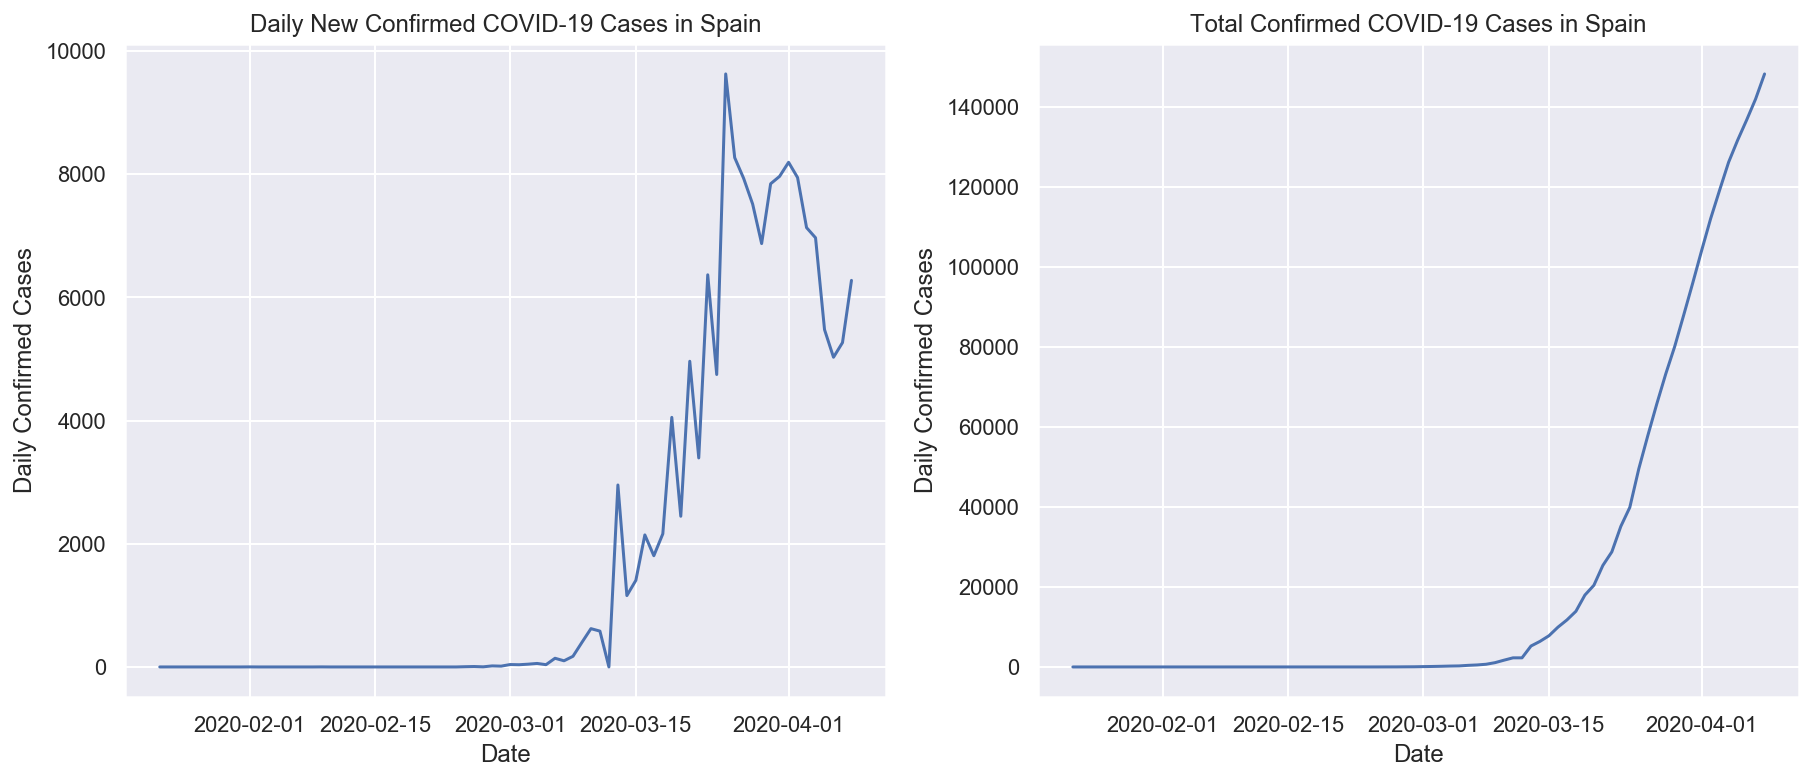

In [6]:
spain = create_country("Spain", end_date = "2020-04-08")

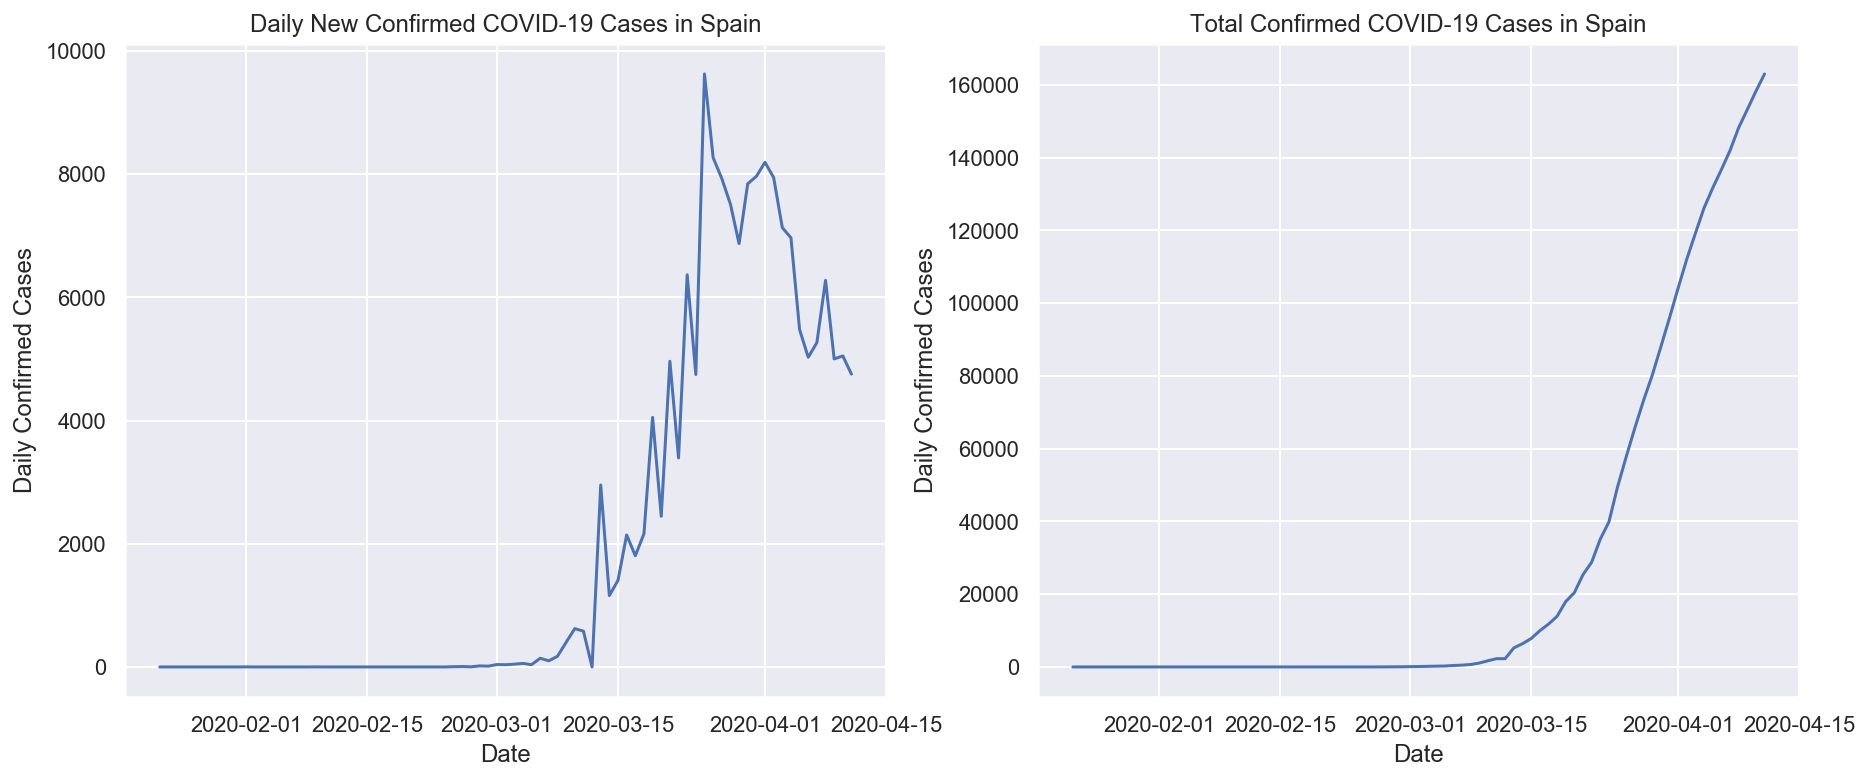

In [7]:
spain2 = create_country("Spain", end_date = "2020-04-12")

In [8]:
spain_start = "2020-02-25"
spain = spain[spain.date >= spain_start].reset_index(drop = True)

spain["days_since_start"] = np.arange(spain.shape[0]) + 1

# no cases on march 12th but 2900 cases on march 13th
num_cases = 1450
spain.loc[spain.date == "2020-03-12", "daily_confirmed"] = num_cases # add cases to march12th
spain.loc[spain.date == "2020-03-13", "daily_confirmed"] -= num_cases # subtract the cases from march13th

spain2 = spain2[spain2.date >= spain_start].reset_index(drop = True)
spain2["days_since_start"] = np.arange(spain2.shape[0]) + 1
# no cases on march 12th but 2900 cases on march 13th
spain2.loc[spain2.date == "2020-03-12", "daily_confirmed"] = num_cases # add cases to march12th
spain2.loc[spain2.date == "2020-03-13", "daily_confirmed"] -= num_cases # subtract the cases from march13th

### Germany

In [ ]:
germany = create_country("Germany", end_date = "2020-04-08")

In [14]:
germany_start = "2020-02-25"
germany = germany[germany.date >= germany_start].reset_index(drop = True)

germany["days_since_start"] = np.arange(germany.shape[0]) + 1

##### Data for Regression

In [42]:
# variable for data to easily swap it out:
country_ = "Spain"
reg_data = spain2.copy()

In [ ]:
# approximate true date of the change for Spain
spain[spain.daily_confirmed > 9000]

#### POC

In [ ]:
### testing out piecewise regression to see if its reasonnable

# just choose a random point to split on. difference here is that we have a closed form solution
_date = 25

# piece 1
df = reg_data[reg_data.days_since_start < _date]
x = np.array(df["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
y = np.log(np.array(df["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg = LinearRegression()
_ = reg.fit(x, y)
print("Regression 1 weight: ", round(reg.coef_[0][0], 2))
print("Regression 1 bias: ", round(reg.intercept_[0], 2))

# piece 2
df2 = reg_data[reg_data.days_since_start >= _date]
x2 = np.array(df2["days_since_start"]).reshape(-1, 1) # predictor is the day number, t
y2 = np.log(np.array(df2["daily_confirmed"]).reshape(-1, 1)) # response is the number of confirmed cases

reg2 = LinearRegression()
_ = reg2.fit(x2, y2)
print("Regression 2 weight: ", round(reg2.coef_[0][0], 2))
print("Regression 2 bias: ", round(reg2.intercept_[0], 2))

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# log regression model
ax[0].scatter(x, y, s = 15);
ax[0].scatter(x2, y2, s = 15, color = "red");
ax[0].plot(x, x*reg.coef_[0][0] + reg.intercept_) 
ax[0].plot(x2, x2*reg2.coef_[0][0] + reg2.intercept_, color = "red") 
ax[0].set(title = "Daily Cases: Piecewise Regression Model - Log Data")

ax[1].scatter(x, np.exp(y), s = 15)
ax[1].scatter(x2, np.exp(y2), s = 15, color = "red")
ax[1].plot(x, np.exp(x*reg.coef_[0][0] + reg.intercept_))
ax[1].plot(x2, np.exp(x2*reg2.coef_[0][0] + reg2.intercept_), color = "red");
ax[1].set(title = "Daily Cases: Piecewise Regression Model - Original Data");

## Change Point Estimation in Pyro

In [43]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [68]:
# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features, b1_mu, b2_mu):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear1.weight = PyroSample(dist.Normal(0.5, 0.5).expand([1, 1]).to_event(1))
        self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
        
        # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
        self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear2.weight = PyroSample(dist.Normal(0., 0.5).expand([1, 1])) #.to_event(1))
        self.linear2.bias = PyroSample(dist.Normal(b2_mu, 1.))

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.Beta(3, 3))
        sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
        # fit lm's to data based on tau
        sep = int(np.ceil(tau.detach().numpy() * len(x)))
        mean1 = self.linear1(x[:sep]).squeeze(-1)
        mean2 = self.linear2(x[sep:]).squeeze(-1)
        mean = torch.cat((mean1, mean2))
        # sample from the posterior
        obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [69]:
tensor_data = torch.tensor(reg_data[["daily_confirmed", "days_since_start"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])

# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.2)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.8)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

Prior mean for Bias 1:  2.8131225
Prior mean for Bias 2:  8.976123


#### Approximate Inference with Stochastic Variational Inference

In [70]:
model = BayesianRegression(1, 1, 
                           b1_mu = bias_1_mean,
                           b2_mu = bias_2_mean)
auto_guide = AutoDiagonalNormal(model)
svi = SVI(model = model, # bayesian regression class
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.1}), # optimizer
          loss=Trace_ELBO()) # loss function

num_iterations = 7500
# param_store is where pyro stores param estimates
pyro.clear_param_store()
# inference loop
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 750 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_data)))

[iteration 0001] loss: 4.5780
[iteration 0751] loss: 2.3193
[iteration 1501] loss: 2.0899
[iteration 2251] loss: 2.1133
[iteration 3001] loss: 2.0277
[iteration 3751] loss: 1.7599
[iteration 4501] loss: 2.5243
[iteration 5251] loss: 1.6250
[iteration 6001] loss: 2.2794
[iteration 6751] loss: 2.3372


AutoDiagonalNormal()

In [71]:
auto_guide.requires_grad_(False)
num_samples = 2000
predictive = Predictive(model = model, 
                        guide = auto_guide, 
                        num_samples = num_samples,
                        return_sites=("linear1.weight", "linear1.bias", 
                                      "linear2.weight", "linear2.bias", 
                                      "tau", "sigma", "_RETURN", "obs"))
samples = predictive(x_data)

pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma

predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_daily_confirmed": y_data,
})
predictions.head()

#### HMC with NUTS

In [ ]:
model = BayesianRegression(1, 1, 
                           b1_mu = bias_1_mean,
                           b2_mu = bias_2_mean)
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=200,
            warmup_steps = 50,
            num_chains = 4)
mcmc.run(x_data, y_data)
samples = mcmc.get_samples()
samples.keys()

### Model Diagnostics

In [ ]:
lambda_1_post = samples["linear1.weight"].detach().numpy()
lambda_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

w1 = np.median(lambda_1_post)
b1 = np.median(bias_1_post)

w2 = np.median(lambda_2_post)
b2 = np.median(bias_2_post)

tau = np.median(tau_post)
ind = int(np.ceil(tau * len(x_data)))

22
2020-03-18 00:00:00


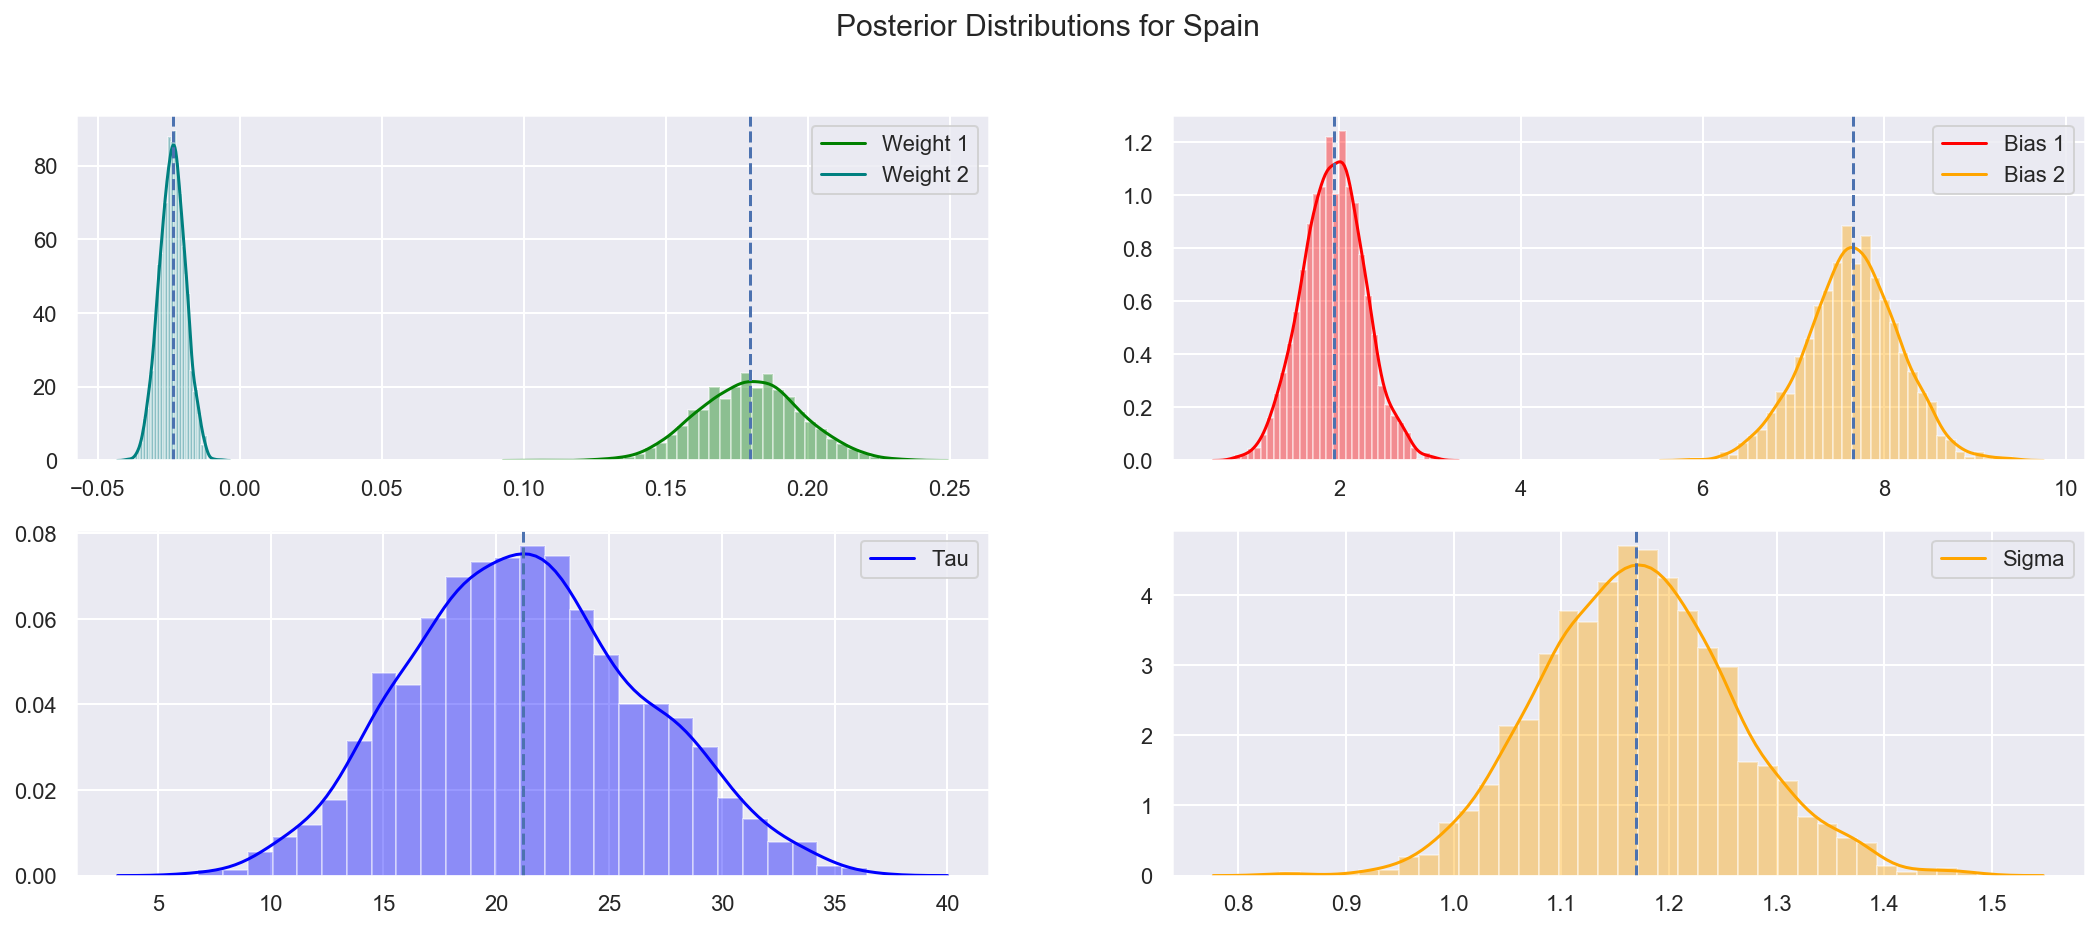

In [73]:
print(ind)
print(reg_data.date[ind])

fig, ax = plt.subplots(2,2, figsize=(18, 7))
plt.suptitle("Posterior Distributions for %s" % country_, fontsize=15)

sns.distplot(lambda_1_post, 
             kde_kws = {"label": "Weight 1"}, 
             color = "green",
             norm_hist = True,
             kde = True,
             ax = ax[0, 0])
ax[0, 0].axvline(x = np.median(lambda_1_post), linestyle = '--')

sns.distplot(lambda_2_post, 
             kde_kws = {"label": "Weight 2"}, 
             color = "teal",
             norm_hist = True,
             kde = True,
             ax = ax[0, 0])
ax[0, 0].axvline(x = np.median(lambda_2_post), linestyle = '--')

sns.distplot(bias_1_post, 
             kde_kws = {"label": "Bias 1"}, 
             color = "red",
             norm_hist = True,
             kde = True,
             ax = ax[0, 1]);
ax[0, 1].axvline(x = np.median(bias_1_post), linestyle = '--')

sns.distplot(bias_2_post, 
             kde_kws = {"label": "Bias 2"}, 
             color = "orange",
             norm_hist = True,
             kde = True,
             ax = ax[0, 1])
ax[0, 1].axvline(x = np.median(bias_2_post), linestyle = '--');

sns.distplot(tau_post * len(y_data), 
             kde_kws = {"label": "Tau"}, 
             color = "blue",
             norm_hist = True,
             kde = True,
             ax = ax[1, 0])
ax[1, 0].axvline(x = np.median(tau_post * len(y_data)), linestyle = '--')

sns.distplot(sigma_post, 
             kde_kws = {"label": "Sigma"}, 
             color = "orange",
             norm_hist = True,
             kde = True,
             ax = ax[1,1])
ax[1, 1].axvline(x = np.median(sigma_post), linestyle = '--');

**Date of change for Spain: 2020-03-18**

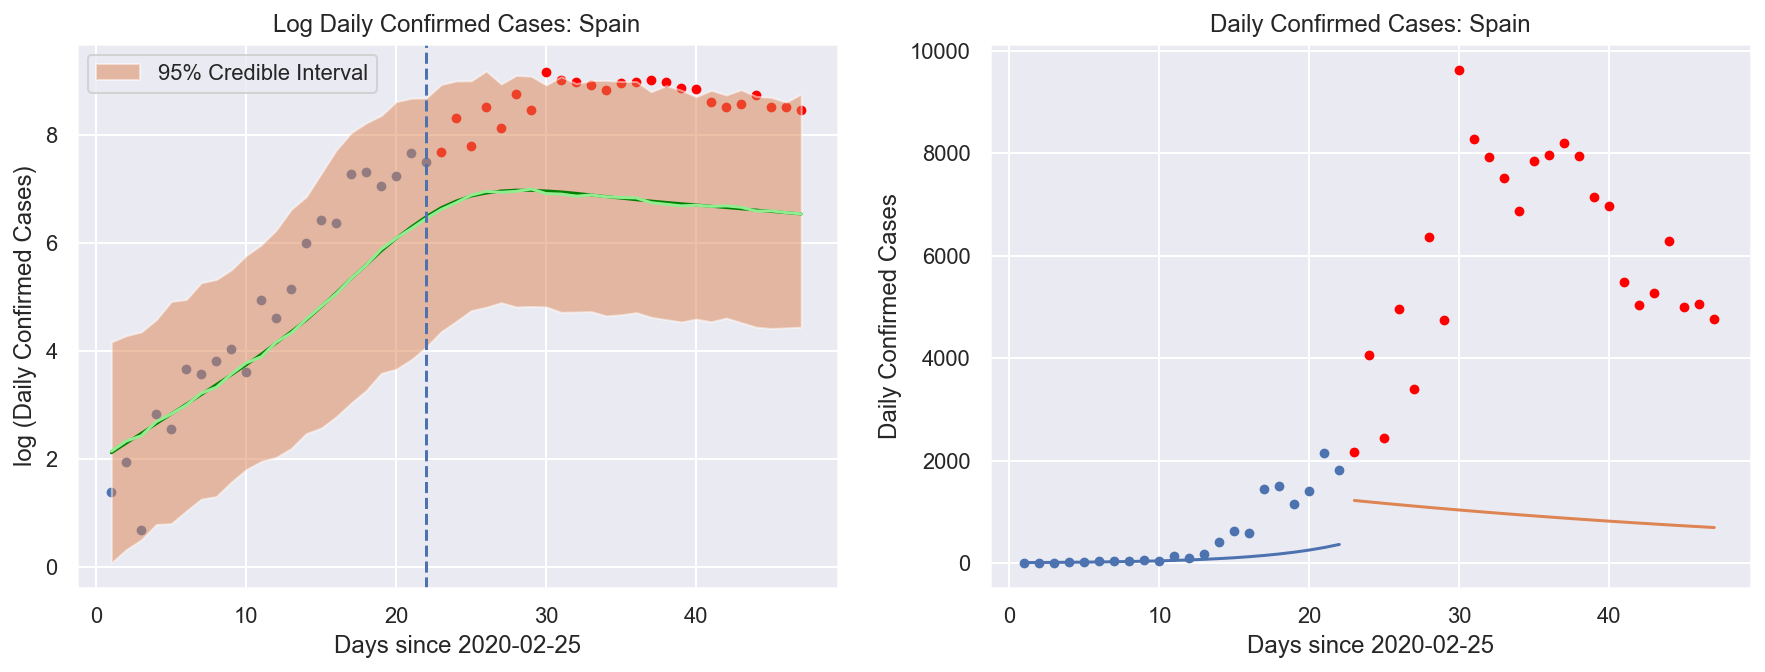

In [74]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
printmd("**Date of change for {}: {}**".format(country_, change_date_))

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# log regression model
ax[0].scatter(y = y_data[:ind], x = x_data[:ind], s = 15);
ax[0].scatter(y = y_data[ind:], x = x_data[ind:], s = 15, color = "red");

#ax[0].plot(x_data[:ind], (x_data[:ind] * w1) + b1) 
#ax[0].plot(x_data[ind:], (x_data[ind:] * w2) + b2) 
ax[0].plot(predictions["days_since_start"], predictions["mu_mean"], color = "green") 
ax[0].plot(predictions["days_since_start"], predictions["y_mean"], color = "lightgreen") 
ax[0].axvline(ind, linestyle = '--')
ax[0].fill_between(predictions["days_since_start"], 
                   predictions["y_perc_5"], 
                   predictions["y_perc_95"], 
                   alpha = 0.5,
                   label = "95% Credible Interval");
ax[0].set(ylabel = "log (Daily Confirmed Cases)", 
          xlabel = "Days since %s" % start_date_, 
          title = "Log Daily Confirmed Cases: %s" % country_)
ax[0].legend(loc = "upper left")

ax[1].scatter(y = reg_data.daily_confirmed[:ind], x = x_data[:ind], s = 15);
ax[1].scatter(y = reg_data.daily_confirmed[ind:], x = x_data[ind:], s = 15, color = "red");

ax[1].plot(reg_data.days_since_start[:ind], np.exp((x_data[:ind] * w1 + b1)))
ax[1].plot(reg_data.days_since_start[ind:], np.exp((x_data[ind:] * w2 + b2)))
# ax[1].fill_between(np.exp(predictions["days_since_start"]), 
#                    np.exp(predictions["y_perc_5"]), 
#                    np.exp(predictions["y_perc_95"]), 
#                    alpha = 0.5);
ax[1].set(ylabel = "Daily Confirmed Cases", 
          xlabel = "Days since %s" % start_date_,
          title = "Daily Confirmed Cases: %s" % country_);

**Date of change for Spain: 2020-03-17 00:00:00**

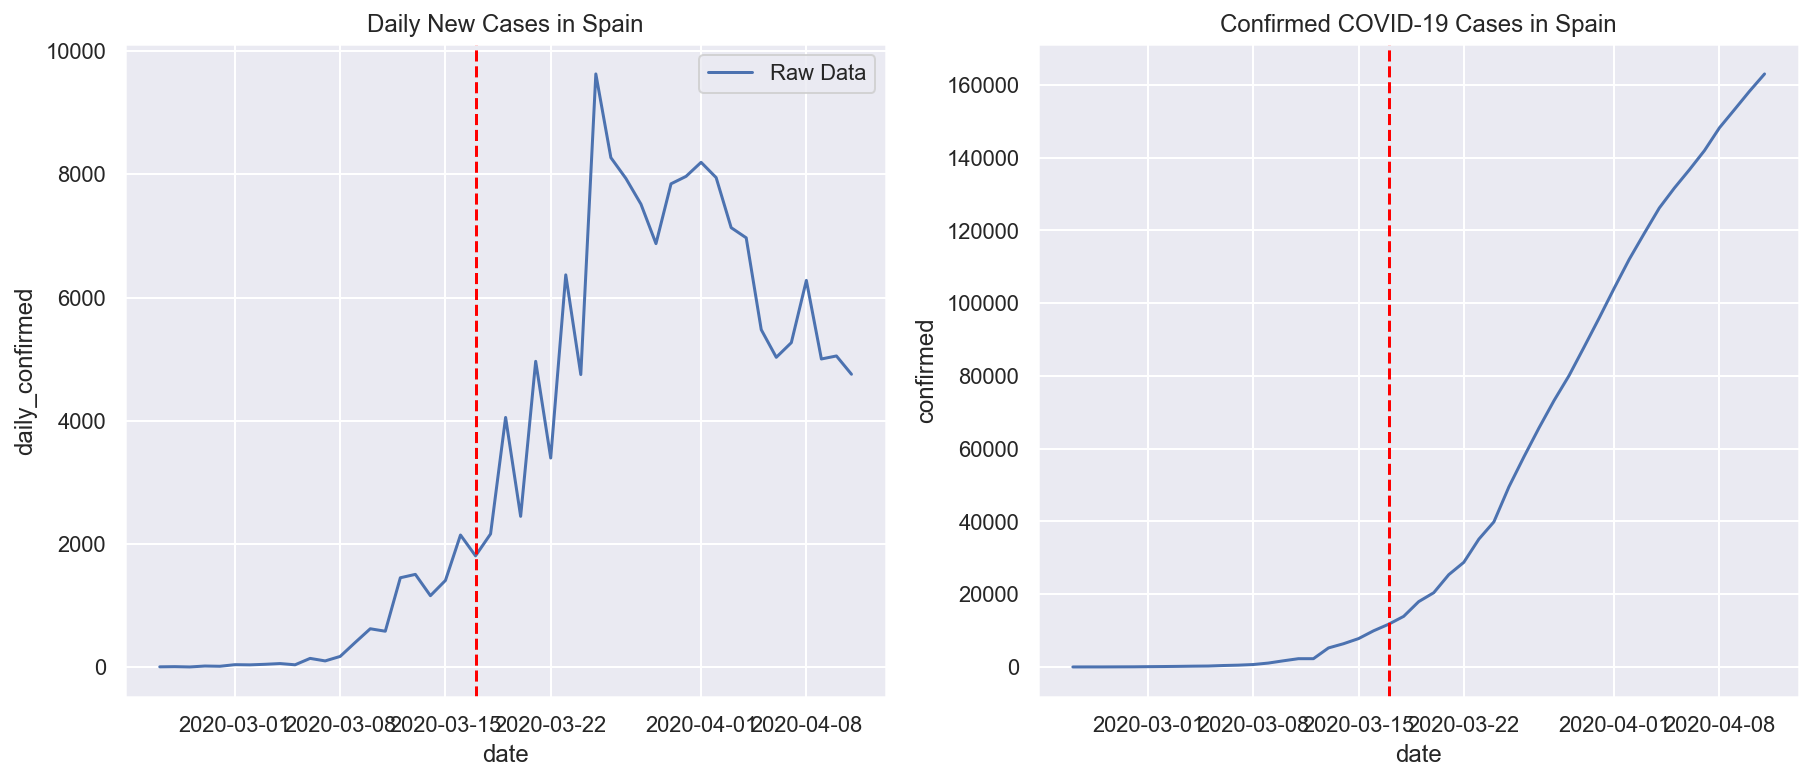

In [66]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

# plot daily confirmed cases, along with moving average
sns.lineplot(x = "date", 
             y = "daily_confirmed", 
             data = reg_data,
             label = "Raw Data",
             ax = ax[0]).set_title("Daily New Cases in %s" % country_)

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= reg_data,
             ax = ax[1]
            ).set_title("Confirmed COVID-19 Cases in %s" % country_)

ax[0].axvline(reg_data.date[ind], color="red", linestyle="--")
ax[1].axvline(reg_data.date[ind], color="red", linestyle="--")
printmd("**Date of change for {}: {}**".format(country_, reg_data.date[ind]));